In [3]:
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from IPython.display import Image
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import re
import os
np.set_printoptions(precision=4, linewidth=100)

In [4]:
os.chdir('C:/Personals/GWU/202103_Programming for Analytics II_DNSC_6303_10/Assignmnt4/')

In [5]:
# check what type of data we are working with
remax = pd.read_csv("REMAX.csv")
remax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [6]:
# add the constant
X = sm.add_constant(remax['price'])
X.head(5)

,const,price
0,1.0,13300000
1,1.0,12250000
2,1.0,12250000
3,1.0,12215000
4,1.0,11410000


In [7]:
# set the dependent variable
Y = remax['price']
# split the data, 80:20 - Train:Test
train_X, test_X, train_y, test_y = train_test_split( X ,Y,train_size = 0.8,random_state = 100 )
# set the independent variables
X_features = ['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']
X_features

['area',
 'bedrooms',
 'bathrooms',
 'stories',
 'mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'parking',
 'prefarea',
 'furnishingstatus']

In [8]:
# convert catagorical data into levels, always creates levels, n-1
remax['mainroad'].unique()
pd.get_dummies(remax['mainroad'])
remax['guestroom'].unique()
pd.get_dummies(remax['guestroom'])
remax['basement'].unique()
pd.get_dummies(remax['basement'])
remax['hotwaterheating'].unique()
pd.get_dummies(remax['hotwaterheating'])
remax['airconditioning'].unique()
pd.get_dummies(remax['airconditioning'])
remax['prefarea'].unique()
pd.get_dummies(remax['prefarea'])
remax['furnishingstatus'].unique()
pd.get_dummies(remax['furnishingstatus']).head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [9]:
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating','airconditioning','prefarea','furnishingstatus']
remax.encoded = pd.get_dummies(remax[X_features],
columns = categorical_features,
                              drop_first = True)
X_features = remax.encoded.columns
X_features

Index(['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_yes',
       'guestroom_yes', 'basement_yes', 'hotwaterheating_yes',
       'airconditioning_yes', 'prefarea_yes',
       'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished'],
      dtype='object')

In [10]:
# add constant (intercept) and assign dependent variable 'price'
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
X = sm.add_constant(remax.encoded)
Y = remax['price']
train_X, test_X, train_y, test_y = train_test_split( X ,Y,train_size = 0.8,random_state = 40 )
# run the first linear regression model
remax_model1 = sm.OLS(train_y, train_X.astype(float)).fit()
print(remax_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     71.45
Date:                Mon, 28 Feb 2022   Prob (F-statistic):           7.21e-98
Time:                        02:32:03   Log-Likelihood:                -6647.6
No. Observations:                 436   AIC:                         1.332e+04
Df Residuals:                     422   BIC:                         1.338e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [11]:
# detecting multicollinearity using variance inflation factors
from statsmodels.stats.outliers_influence import variance_inflation_factor
def get_vif_factors( X ):
    X_matrix = X.to_numpy()
    vif = [ variance_inflation_factor( X_matrix, i ) for i in range( X_matrix.shape[1] ) ]
    vif_factors = pd.DataFrame()
    vif_factors['column'] = X.columns
    vif_factors['vif'] = vif
    return vif_factors
vif_factors = get_vif_factors( X[X_features])
vif_factors

,column,vif
0,area,8.276447
1,bedrooms,16.652387
2,bathrooms,9.417643
3,stories,7.880730
4,parking,1.986400
5,mainroad_yes,6.884806
6,guestroom_yes,1.473234
7,basement_yes,2.019858
8,hotwaterheating_yes,1.091568
9,airconditioning_yes,1.767753


In [12]:
columns_with_large_vif = vif_factors[vif_factors.vif > 4].column
columns_with_large_vif

0            area
1        bedrooms
2       bathrooms
3         stories
5    mainroad_yes
Name: column, dtype: object

In [13]:
# remove the columns that have high multicollinearity
columns_to_be_removed = ['area','bedrooms','bathrooms','stories','mainroad_yes']
X_new_features = list(set(X_features)-set(columns_to_be_removed))
get_vif_factors(X[X_new_features])

,column,vif
0,prefarea_yes,1.381842
1,basement_yes,1.770562
2,furnishingstatus_semi-furnished,1.448231
3,furnishingstatus_unfurnished,1.183095
4,parking,1.565589
5,guestroom_yes,1.438584
6,hotwaterheating_yes,1.069463
7,airconditioning_yes,1.452597


In [14]:
# run second linear model
train_X = train_X[X_new_features]
remax_model2 = sm.OLS(train_y, train_X).fit()
print(remax_model2.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.848
Model:                            OLS   Adj. R-squared (uncentered):              0.845
Method:                 Least Squares   F-statistic:                              297.9
Date:                Mon, 28 Feb 2022   Prob (F-statistic):                   1.19e-169
Time:                        02:33:04   Log-Likelihood:                         -6938.7
No. Observations:                 436   AIC:                                  1.389e+04
Df Residuals:                     428   BIC:                                  1.393e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

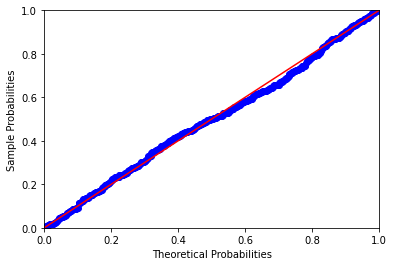

In [15]:
# residual analysis as a visual
import seaborn as sn
%matplotlib inline
def draw_pp_plot( model, title ):
    probplot = sm.ProbPlot( model.resid, fit = True );
    probplot.ppplot( line='45' ); #45-degree line.
draw_pp_plot(remax_model2,"Figure - Normal P-P Plot of Regression Standardized Residuals");

In [17]:
# finding z-score for outlier analysis
from scipy.stats import zscore
remax['z_score_price'] = zscore(remax['price'])
# outlier would lie in plus or minus 3 standard deviations
remax[(remax.z_score_price > 3.0) | (remax.z_score_price < -3.0)].head(20)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,z_score_price
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished,4.566365
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished,4.004484
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished,4.004484
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished,3.985755
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished,3.554979
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished,3.255309


In [19]:
# drop the rows
train_X_new = train_X.drop( [50,111,127],axis=0)
train_y_new = train_y.drop( [50,111,127],axis=0)
# transform the response variable
train_y = np.sqrt(train_y)
# run the third linear regression
remax_model3 = sm.OLS(train_y, train_X).fit()
print(remax_model3.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.865
Method:                 Least Squares   F-statistic:                              350.7
Date:                Mon, 28 Feb 2022   Prob (F-statistic):                   1.24e-182
Time:                        02:34:08   Log-Likelihood:                         -3528.0
No. Observations:                 436   AIC:                                      7072.
Df Residuals:                     428   BIC:                                      7105.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

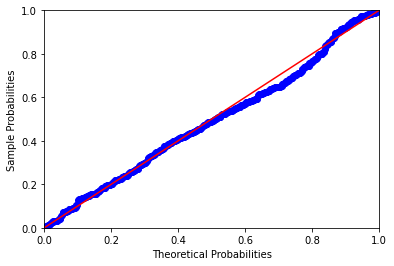

In [20]:
# create a visualisation of the residuals
draw_pp_plot(remax_model3,"Figure - Normal P-P Plot of Regression Standardized Residuals");

In [21]:
# prediction on validation set
pred_y = np.power(remax_model3.predict(test_X[train_X.columns]), 2)
#measuring RMSE
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(pred_y, test_y))

3338283.1066996134

In [22]:
#measuring R^2 value
np.round(metrics.r2_score(pred_y, test_y), 2)

0.12

I think the variables which really impact the price the most was furnishing status and bedrooms. In the first regression, bedrooms had the most impact but once we removed that due to multicollinearity, it turned to furnishing status. Overall, after adjusting the model and dropping the insignificant variables, the model has a high R squared valuing, meaning that the data does fit the model quite well in predicting house price.